# Theme 3 - Turbulent Mixing and Biophysical Interactions

## NOTE: need to re-run when Redmine ticket 14504 is answered

OOI Data Labs Education Nuggets

**Objective**: Demonstrate how to download CTD and Bulk Meteorology data from a Pioneer surface mooring using the Machine-to-Machine (M2M) interface, remove outliers and export the data as a .csv file.

In [1]:
# Notebook Setup
import requests
import os
import re
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 1. Request Data from OOINet

* **Coastal Pioneer** - CTD and Bulk Meteorology data from the Pioneer Inshore Surface Mooring
    * Instruments, delivery method, data streams, parameters:
        * CP03ISSM-SBD11-06-METBKA000 (surface)
            * recovered_host, metbk_a_dcl_instrument_recovered: precipitation, sea_surface_temperature, met_salsurf, met_relwind_speed, met_current_speed
        * CP03ISSM-RID27-03-CTDBPC000 (7m depth)
            * recovered_inst, ctdbp_cdef_instrument_recovered: ctdbp_seawater_pressure, ctdbp_seawater_temperature, practical_salinity, density
    * Time range: 2016-09-03 to 2016-09-10 - passage of extratropical storm Hermine

The **request_data** function below sends data requests with inputs specified by the user to OOINet and returns the THREDDs urls where the downloaded data files can be found.

In [2]:
# enter your OOI API username and token, and directory where output .csv files are saved
API_USERNAME = ''
API_TOKEN = ''
save_dir = '/Users/lgarzio/Documents/OOI/Nuggets/'

In [3]:
def request_data(reference_designator, method, stream, start_date=None, end_date=None):
    site = reference_designator[:8]
    node = reference_designator[9:14]
    instrument = reference_designator[15:]

    # Create the request URL
    api_base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv'
    data_request_url = '/'.join((api_base_url, site, node, instrument, method, stream))

    # All of the following are optional, but you should specify a date range
    params = {
        'format': 'application/netcdf',
        'include_provenance': 'true',
        'include_annotations': 'true'
    }
    if start_date:
        params['beginDT'] = start_date
    if end_date:
        params['endDT'] = end_date

    # Make the data request
    r = requests.get(data_request_url, params=params, auth=(API_USERNAME, API_TOKEN))
    data = r.json()

    # Return just the THREDDS URL
    return data['allURLs'][0]

Now, use that **request_data** function to download data for the three instruments of interest. You only need to do this once! These lines are commented out to prevent accidental re-submission of data requests.

In [4]:
# METBK_url = request_data('CP03ISSM-SBD11-06-METBKA000', 'recovered_host', 'metbk_a_dcl_instrument_recovered',
#                          '2016-09-03T00:00:00.000Z', '2016-09-10T00:00:00.000Z')
#
# CTD_url = request_data('CP03ISSM-RID27-03-CTDBPC000', 'recovered_inst', 'ctdbp_cdef_instrument_recovered',
#                        '2016-09-03T00:00:00.000Z', '2016-09-10T00:00:00.000Z')
#
# print('METBK_url: %s' %METBK_url)
# print('CTD_url: %s' %CTD_url)

## 2. Load Data Files

Copy the links to the THREDDs catalog above that resulted from the **request_data** function (to avoid re-requesting the data). Note: the urls must be surrounded by quotations. Depending on the data request, it may take several minutes for the request to fulfill. The request is complete when you receive an email from the system with the link to your data, and a status.txt file shows up in the THREDDs catalog that says "Complete".

In [5]:
METBK_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/lgarzio@marine.rutgers.edu/20191028T193309098Z-CP03ISSM-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered/catalog.html'
CTD_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/lgarzio@marine.rutgers.edu/20191028T193309372Z-CP03ISSM-RID27-03-CTDBPC000-recovered_inst-ctdbp_cdef_instrument_recovered/catalog.html'

The **get_data** function below:
* selects the appropriate datasets in a THREDDs catalog by selecting NetCDF files, removing collocated datasets (if provided), and removing deployments that aren't specified (if provided)
* creates an empty dictionary with placeholders to populate with data just for variables of interest
* creates another dictionary to store the units for the variables of interest
* opens the dataset(s), extracts the data and units for the variables of interest and adds them to the dictionaries
* converts the data dictionary to a dataframe
* returns the dataframe and the dictionary containing the variable units. 

This type of function is most useful when working with multiple large/dense datasets, but is also fine for working with smaller datasets.

In [6]:
def get_data(url, variables, deployments=None):
    # Function to grab all data from specified directory
    tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
    dataset = requests.get(url).text
    ii = re.findall(r'href=[\'"]?([^\'" >]+)', dataset)
    # x = re.findall(r'(ooi/.*?.nc)', dataset)
    x = [y for y in ii if y.endswith('.nc')]
    for i in x:
        if i.endswith('.nc') == False:
            x.remove(i)
    for i in x:
        try:
            float(i[-4])
        except:
            x.remove(i)
    # dataset = [os.path.join(tds_url, i) for i in x]
    datasets = [os.path.join(tds_url, i.split('=')[-1]) for i in x]

    # remove deployments not in deployment list, if given
    if deployments is not None:
        deploy = ['deployment{:04d}'.format(j) for j in deployments]
        datasets = [k for k in datasets if k.split('/')[-1].split('_')[0] in deploy]

    # remove collocated data files if necessary
    catalog_rms = url.split('/')[-2][20:]
    selected_datasets = []
    for d in datasets:
        if catalog_rms == d.split('/')[-1].split('_20')[0][15:]:
            selected_datasets.append(d)

    # create a dictionary to populate with data from the selected datasets
    data_dict = {'time': np.array([], dtype='datetime64[ns]')}
    unit_dict = {}
    for v in variables:
        data_dict.update({v: np.array([])})
        unit_dict.update({v: []})
    print('Appending data from files')

    for sd in selected_datasets:
        ds = xr.open_dataset(sd, mask_and_scale=False)
        data_dict['time'] = np.append(data_dict['time'], ds['time'].values)
        for var in variables:
            data_dict[var] = np.append(data_dict[var], ds[var].values)
            units = ds[var].units
            if units not in unit_dict[var]:
                unit_dict[var].append(units)

    # convert dictionary to a dataframe
    df = pd.DataFrame(data_dict)
    df.sort_values(by=['time'], inplace=True)  # make sure the timestamps are in ascending order

    return df, unit_dict

Now we can specify the variables of interest and get the data for the three datasets.

In [7]:
# Specify the variable(s) of interest and get the data for the three datasets
METBK_var = ['precipitation', 'sea_surface_temperature', 'met_salsurf', 'met_relwind_speed', 'met_current_speed']
CTD_var = ['ctdbp_seawater_pressure', 'ctdbp_seawater_temperature', 'practical_salinity', 'density']

METBK_data, METBK_units = get_data(METBK_url, METBK_var)
CTD_data, CTD_units = get_data(CTD_url, CTD_var)

print(METBK_units)
print(CTD_units)

Appending data from files
Appending data from files
{'precipitation': ['mm'], 'sea_surface_temperature': ['ºC'], 'met_salsurf': ['1'], 'met_relwind_speed': ['m s-1'], 'met_current_speed': ['m s-1']}
{'ctdbp_seawater_pressure': ['dbar'], 'ctdbp_seawater_temperature': ['ºC'], 'practical_salinity': ['1'], 'density': ['kg m-3']}


## Quick Data Plots
First, make quick time-series plots.

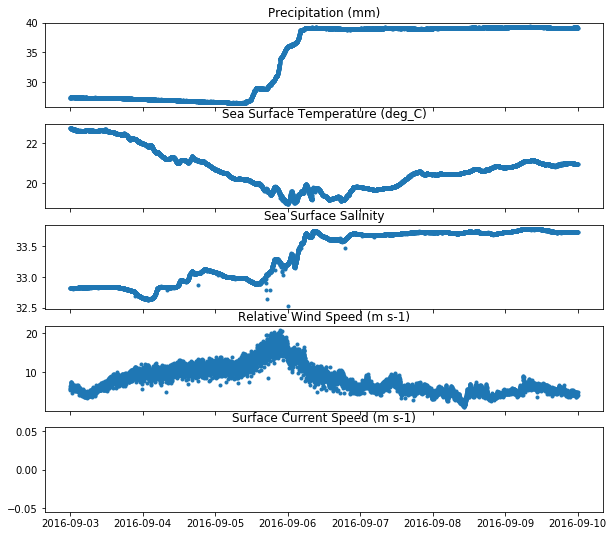

In [8]:
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5,1, sharex=True, figsize=(10,9))
ax1.plot(METBK_data['time'], METBK_data['precipitation'], '.')
ax1.set_xlabel('')
ax1.set_title('Precipitation ({})'.format(METBK_units['precipitation'][0]))

ax2.plot(METBK_data['time'], METBK_data['sea_surface_temperature'], '.')
ax2.set_xlabel('')
ax2.set_title('Sea Surface Temperature (deg_C)')

ax3.plot(METBK_data['time'], METBK_data['met_salsurf'], '.')
ax3.set_xlabel('')
ax3.set_title('Sea Surface Salinity')

ax4.plot(METBK_data['time'], METBK_data['met_relwind_speed'], '.')
ax4.set_xlabel('')
ax4.set_title('Relative Wind Speed ({})'.format(METBK_units['met_relwind_speed'][0]))

ax5.plot(METBK_data['time'], METBK_data['met_current_speed'], '.')
ax5.set_xlabel('')
ax5.set_title('Surface Current Speed ({})'.format(METBK_units['met_current_speed'][0]));

The precipitation data provided by the OOI are cumulative - there is a reservoir that collects rainwater that periodically empties so the measurements can start again. So, the user needs to calculate rate of precipitation. For this example, we will calculate 15 minute averages, then calculate consecutive differences (to determine how much rain fell over those 15 minutes), then resample hourly to get hourly precipitation. Originally written by Sage Lichtenwalner

In [10]:
# calculate rate of precipitation
precip = METBK_data.drop(columns=['sea_surface_temperature', 'met_salsurf', 'met_relwind_speed', 'met_current_speed'])

# calculate the 15 minute average, and the difference from the line above (since precipitation is cumulative)
precip = precip.resample('15min', on='time').mean().diff()
precip = precip.where(precip > 0).reset_index()  # get rid of negative differences
precip = precip.resample('H', on='time').sum().reset_index()  # add up values to get hourly precipitation
precip = precip.rename(columns={'precipitation': 'Precipitation ({} hour-1)'.format(METBK_units['precipitation'][0])})

Plot hourly precipitation

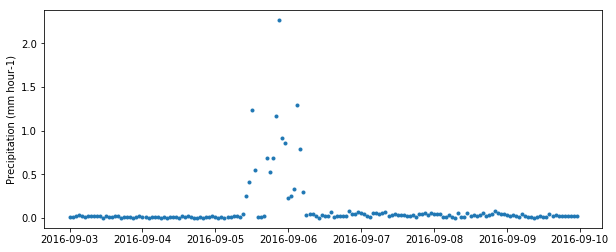

In [11]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(precip['time'], precip['Precipitation (mm hour-1)'], '.')
ax.set_xlabel('')
ax.set_ylabel('Precipitation (mm hour-1)');

Now plot the data from the CTD deployed at 7m depth.

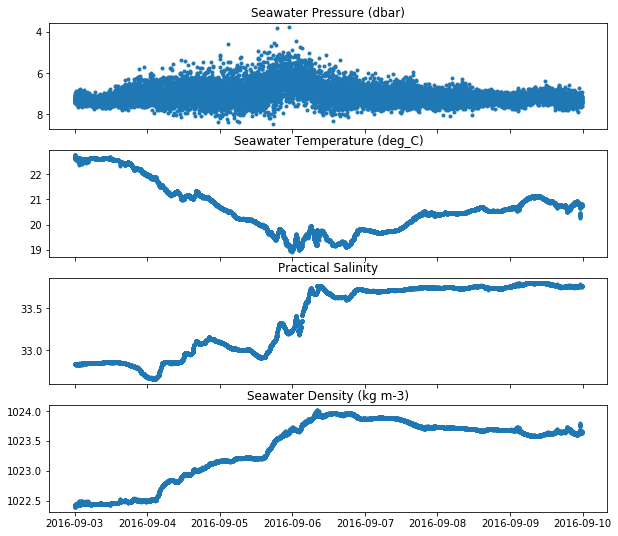

In [12]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, sharex=True, figsize=(10,9))
ax1.plot(CTD_data['time'], CTD_data['ctdbp_seawater_pressure'], '.')
ax1.invert_yaxis()
ax1.set_xlabel('')
ax1.set_title('Seawater Pressure ({})'.format(CTD_units['ctdbp_seawater_pressure'][0]))

ax2.plot(CTD_data['time'], CTD_data['ctdbp_seawater_temperature'], '.')
ax2.set_xlabel('')
ax2.set_title('Seawater Temperature (deg_C)')

ax3.plot(CTD_data['time'], CTD_data['practical_salinity'], '.')
ax3.set_xlabel('')
ax3.set_title('Practical Salinity')

ax4.plot(CTD_data['time'], CTD_data['density'], '.')
ax4.set_xlabel('')
ax4.set_title('Seawater Density ({})'.format(CTD_units['density'][0]));

## 3. Merge and export
Let's work on merging and exporting the datasets as a .csv file. We will calculate hourly averages to make the .csv file easier to work with, and will merge the METBK and CTD data together. We will drop the precipitation variable from the METBK dataset because we already calculated the hourly averages above. We will merge that precipitation dataframe that we created back in when we do the dataframe merge.

In [13]:
# drop the precipitation column
METBK_data = METBK_data.drop(columns=['precipitation'])

# calculate hourly averages for both datasets
METBK_data_hourly = METBK_data.resample('H', on='time').mean().reset_index()
CTD_data_hourly = CTD_data.resample('H', on='time').mean().reset_index()

# rename the columns and add units
METBK_data_hourly = METBK_data_hourly.rename(columns={'sea_surface_temperature': 'Sea Surface Temperature (deg_C)',
                                          'met_salsurf': 'Sea Surface Salinity',
                                          'met_relwind_speed': 'Relative Wind Speed ({})'.format(METBK_units['met_relwind_speed'][0]),
                                          'met_current_speed': 'Surface Current Speed ({})'.format(METBK_units['met_current_speed'][0])})

# add '7m' to the columns to remind the user that these data are from the CTD at 7m depth, rather than the surface METBK
CTD_data_hourly = CTD_data_hourly.rename(columns={'ctdbp_seawater_pressure': 'Seawater Pressure 7m ({})'.format(CTD_units['ctdbp_seawater_pressure'][0]),
                                          'ctdbp_seawater_temperature': 'Seawater Temperature 7m (deg_C)',
                                          'practical_salinity': 'Practical Salinity 7m',
                                          'density': 'Seawater Density 7m ({})'.format(CTD_units['density'][0])})

# add precipitation back into the METBK data frame
METBK_merge = pd.merge(METBK_data_hourly, precip, on='time', how='outer')

# merge the METBK and CTD data
merged = pd.merge(METBK_merge, CTD_data_hourly, on='time', how='outer')

Remake the plots above using the new downsampled dataset

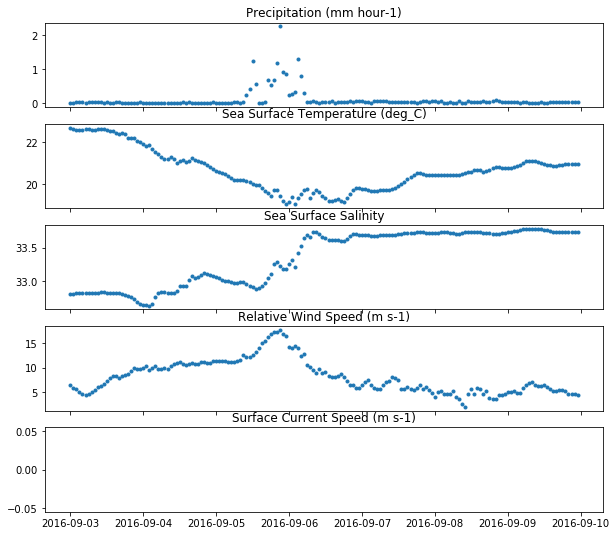

In [15]:
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(5,1, sharex=True, figsize=(10,9))
ax1.plot(merged['time'], merged['Precipitation (mm hour-1)'], '.')
ax1.set_xlabel('')
ax1.set_title('Precipitation (mm hour-1)')

ax2.plot(merged['time'], merged['Sea Surface Temperature (deg_C)'], '.')
ax2.set_xlabel('')
ax2.set_title('Sea Surface Temperature (deg_C)')

ax3.plot(merged['time'], merged['Sea Surface Salinity'], '.')
ax3.set_xlabel('')
ax3.set_title('Sea Surface Salinity')

ax4.plot(merged['time'], merged['Relative Wind Speed (m s-1)'], '.')
ax4.set_xlabel('')
ax4.set_title('Relative Wind Speed (m s-1)')

ax5.plot(merged['time'], merged['Surface Current Speed (m s-1)'], '.')
ax5.set_xlabel('')
ax5.set_title('Surface Current Speed (m s-1)');

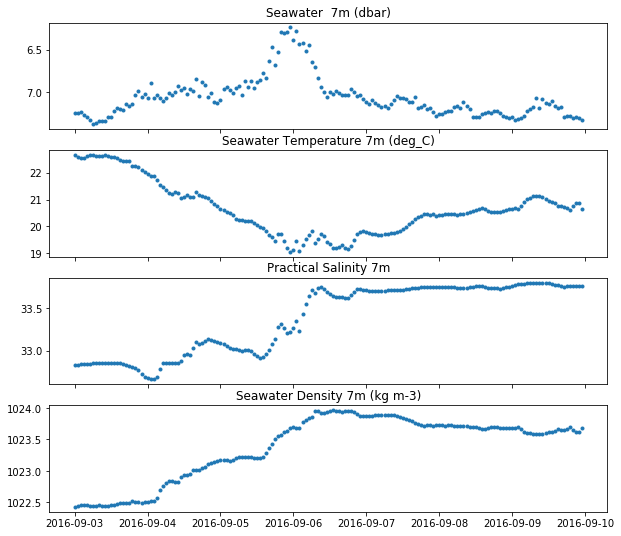

In [16]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, sharex=True, figsize=(10,9))
ax1.plot(merged['time'], merged['Seawater Pressure 7m (dbar)'], '.')
ax1.invert_yaxis()
ax1.set_xlabel('')
ax1.set_title('Seawater  7m ({})'.format(CTD_units['ctdbp_seawater_pressure'][0]))

ax2.plot(merged['time'], merged['Seawater Temperature 7m (deg_C)'], '.')
ax2.set_xlabel('')
ax2.set_title('Seawater Temperature 7m (deg_C)')

ax3.plot(merged['time'], merged['Practical Salinity 7m'], '.')
ax3.set_xlabel('')
ax3.set_title('Practical Salinity 7m')

ax4.plot(merged['time'], merged['Seawater Density 7m (kg m-3)'], '.')
ax4.set_xlabel('')
ax4.set_title('Seawater Density 7m ({})'.format(CTD_units['density'][0]));

Looks good! Let's export as a .csv file.

In [17]:
merged.to_csv(os.path.join(save_dir, 'Theme3_Hermine_Pioneer_Inshore_Surface_Mooring.csv'), index=False)